In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [44]:
train = pd.read_csv('data/train.csv')

test = pd.read_csv('data/test.csv')

display(train)

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59994,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59995,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
train, validation = train_test_split(train,train_size=0.8,random_state=42)

In [56]:
y_train = train.iloc[:,0]
X_train = train.drop(train.columns[0],axis=1)

y_validation = validation.iloc[:,0]
X_validation = validation.drop(validation.columns[0],axis=1)

y_test = test.iloc[:,0]
X_test = test.drop(test.columns[0],axis=1)

In [57]:
import torch
import torch.nn as nn
import torchvision.ops as ops
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [76]:
X_train_tensors = torch.tensor(X_train.values,dtype=torch.float32)
y_train_tensors = torch.tensor(y_train.values,dtype=torch.long)

dataset_train = TensorDataset(X_train_tensors,y_train_tensors)
train_loader = DataLoader(dataset_train,batch_size=64,shuffle=True)

X_validation_tensors = torch.tensor(X_validation.values,dtype=torch.float32)
y_validation_tensors = torch.tensor(y_validation.values,dtype=torch.long)

dataset_validation = TensorDataset(X_validation_tensors,y_validation_tensors)
validation_loader = DataLoader(dataset_validation)

X_test_tensors = torch.tensor(X_test.values,dtype=torch.float32)
y_test_tensors = torch.tensor(y_test.values,dtype=torch.long)

dataset_test = TensorDataset(X_test_tensors,y_test_tensors)
test_loader = DataLoader(dataset_test)

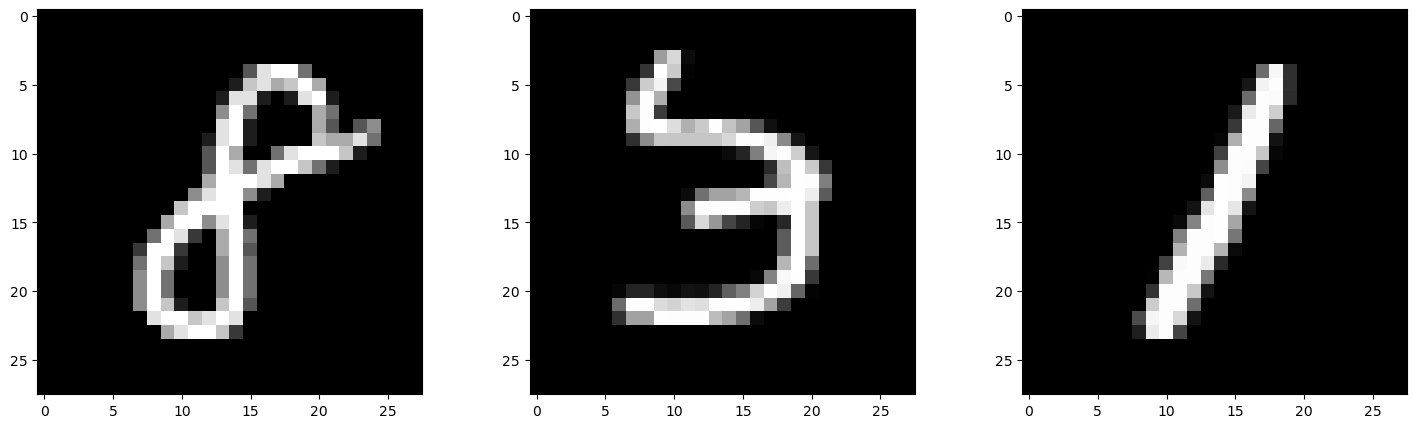

In [59]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(X_train.iloc[i].values.reshape(28,28), cmap='gray')
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

In [62]:
#!pip install torch

In [93]:
import torch 
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

In [79]:
output_size = 10
input_size = X_train.columns[0:].shape[0]

In [97]:
model = nn.Sequential(
    nn.Linear(input_size,64), # input
    nn.ReLU(), # activation
    nn.Linear(64,32), # hidden layer
    nn.ReLU(), # activation
    nn.Linear(32,output_size), # ouput
)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(model.parameters(),lr=0.001) # optimizer

In [98]:
print("Unique labels in y_train:", torch.unique(y_train_tensors))

Unique labels in y_train: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [99]:
# # Number of epochs
# num_epochs = 100  

# for epoch in range(num_epochs):
#     # training mode
#     model.train()

#     # Loop over batches
#     for X_batch, y_batch in train_loader:
#         # Forward pass: compute the output of the model for the batch
#         outputs = model(X_batch)

#         # Compute the loss for the batch
#         loss = criterion(outputs, y_batch)

#         # Backward pass: compute gradients
#         optimizer.zero_grad()  # Clear previous gradients
#         loss.backward()        # Backpropagation

#         # Update the weights
#         optimizer.step()

#     # Print the loss every 10 epochs
#     if (epoch + 1) % 10 == 0:
#         print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy_score(y_batch)}')

In [116]:
def train_nn(model,loader):
    num_epochs = 100

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        # Variables to accumulate predictions and true labels
        all_preds = []
        all_labels = []

        for X_batch, y_batch in train_loader:
            # Forward pass: compute the output of the model
            outputs = model(X_batch)
            
            # Compute the loss
            loss = criterion(outputs, y_batch)

            # Backward pass: compute gradients
            optimizer.zero_grad()  # Clear previous gradients
            loss.backward()        # Backpropagation

            # Update the weights
            optimizer.step()

            # Convert model outputs to predicted class indices
            _, predicted = torch.max(outputs, 1)

            # Accumulate predictions and true labels
            all_preds.extend(predicted.cpu().numpy())  # Convert to numpy and store
            all_labels.extend(y_batch.cpu().numpy())   # Convert to numpy and store

        # Compute metrics at the end of the epoch
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')  # For multi-class problems

        # Print loss, accuracy, and F1 score every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')
        
    return loss.item(), accuracy, f1

In [118]:
loss, accuracy, f1 = train_nn(model,train_loader)

print(f'{loss:.4f}, {accuracy}, {f1}')

Epoch [10/100], Loss: 0.0000, Accuracy: 0.9993, F1 Score: 0.9993
Epoch [20/100], Loss: 0.0001, Accuracy: 0.9966, F1 Score: 0.9966
Epoch [30/100], Loss: 0.0000, Accuracy: 0.9974, F1 Score: 0.9974
Epoch [40/100], Loss: 0.0002, Accuracy: 0.9983, F1 Score: 0.9983
Epoch [50/100], Loss: 0.0002, Accuracy: 0.9982, F1 Score: 0.9982
Epoch [60/100], Loss: 0.0000, Accuracy: 0.9980, F1 Score: 0.9980
Epoch [70/100], Loss: 0.0000, Accuracy: 0.9982, F1 Score: 0.9982
Epoch [80/100], Loss: 0.1468, Accuracy: 0.9978, F1 Score: 0.9978
Epoch [90/100], Loss: 0.0000, Accuracy: 0.9980, F1 Score: 0.9980
Epoch [100/100], Loss: 0.0001, Accuracy: 0.9968, F1 Score: 0.9969
0.0001, 0.9968488762728196, 0.9968561840675131


In [106]:
# # Assuming num_classes is defined and your model is set up correctly
# num_epochs = 100

# for epoch in range(num_epochs):
#     model.train()  # Set model to training mode

#     # Variables to accumulate predictions and true labels
#     all_preds = []
#     all_labels = []

#     for X_batch, y_batch in train_loader:
#         # Forward pass: compute the output of the model
#         outputs = model(X_batch)
        
#         # Compute the loss
#         loss = criterion(outputs, y_batch)

#         # Backward pass: compute gradients
#         optimizer.zero_grad()  # Clear previous gradients
#         loss.backward()        # Backpropagation

#         # Update the weights
#         optimizer.step()

#         # Convert model outputs to predicted class indices
#         _, predicted = torch.max(outputs, 1)

#         # Accumulate predictions and true labels
#         all_preds.extend(predicted.cpu().numpy())  # Convert to numpy and store
#         all_labels.extend(y_batch.cpu().numpy())   # Convert to numpy and store

#     # Compute metrics at the end of the epoch
#     accuracy = accuracy_score(all_labels, all_preds)
#     f1 = f1_score(all_labels, all_preds, average='weighted')  # For multi-class problems

#     # Print loss, accuracy, and F1 score every 10 epochs
#     if (epoch + 1) % 10 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')

In [129]:
def evaluation_nn(model, X_set, y_set):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    with torch.no_grad():  # No need to calculate gradients for validation/testing
        outputs = model(X_set)
        val_loss = criterion(outputs, y_set)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())  # Convert to numpy and store
        all_labels.extend(y_set.cpu().numpy())   # Convert to numpy and store
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')  # For multi-class problems
        
        print(f'Validation Loss: {val_loss.item():.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')


In [126]:
# model.eval()  # Set the model to evaluation mode
# with torch.no_grad():  # No need to calculate gradients for validation/testing
#     outputs = model(X_validation_tensors)
#     val_loss = criterion(outputs, y_validation_tensors)
#     print(f'Validation Loss: {val_loss.item():.4f}')

In [127]:
evaluation_nn(model,X_validation_tensors, y_validation_tensors)

Validation Loss: 3.5958, Accuracy: 0.9620, F1 Score: 0.9620


In [130]:
evaluation_nn(model,X_test_tensors, y_test_tensors)

Validation Loss: 3.2595, Accuracy: 0.9662, F1 Score: 0.9662


In [131]:
# model.eval()  # Set the model to evaluation mode
# all_preds = []
# all_labels = []

# with torch.no_grad():  # No need to calculate gradients for validation/testing
#     outputs = model(X_test_tensors)
#     val_loss = criterion(outputs, y_test_tensors)
#     print(f'Test Loss: {val_loss.item():.4f}')

In [134]:
model_2 = nn.Sequential(
    nn.Linear(input_size,64), # input
    nn.ReLU(), # activation
    nn.Linear(64,32), # hidden layer
    nn.ReLU(), # activation
    nn.Linear(32,64),
    nn.ReLU(),
    nn.Linear(32,output_size), # ouput
)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(model.parameters(),lr=0.001) # optimizer

In [133]:
train_nn(model_2,train_loader)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x10 and 32x10)